In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')

In [2]:
import operator

In [206]:
summary = pd.read_csv('summary_stats.csv')
df = pd.read_excel('XYZ-1.xlsx', 'Data')
demand = df[6:]

In [207]:
summary

,Purchase Cost,Lead Time,Size,Selling Price,Starting Stock,Mean,Std Dev,Co,Ch,Probability,Demand_lead
0,12,9,0.570,16.1,2750,103.501805,37.317994,1000,20,0.756831,705
1,7,6,0.052,8.6,22500,648.551913,26.446797,1200,20,1.000000,3891
2,6,16,0.530,10.2,5200,201.677043,31.079301,1000,20,0.702186,2266
3,37,22,1.050,68.0,1400,150.068965,3.215598,1200,20,0.237705,785


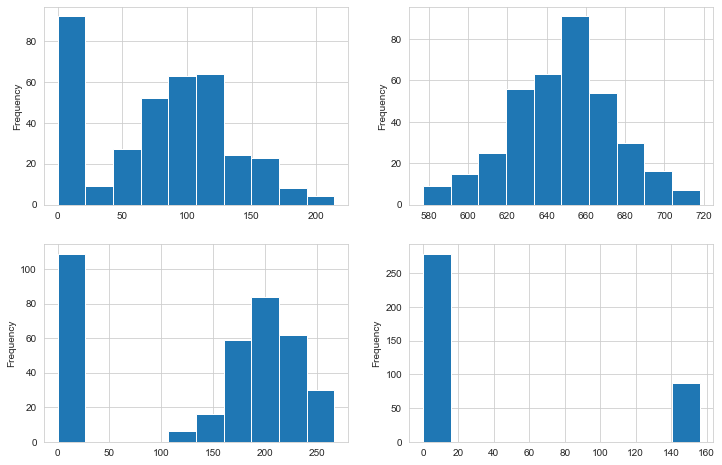

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
demand[1].plot.hist(ax=axes[0, 0])
demand[2].plot.hist(ax=axes[0, 1])
demand[3].plot.hist(ax=axes[1, 0])
demand[4].plot.hist(ax=axes[1, 1])

In [208]:
class Product:
    def __init__(self, i):
        """
        :type i: int - Product number
        """
        self.i = i
        self.unit_cost = summary['Purchase Cost'].iloc[i - 1]
        self.lead_time = summary['Lead Time'].iloc[i - 1]
        self.size = summary['Size'].iloc[i - 1]
        self.selling_price = summary['Selling Price'].iloc[i - 1]
        self.holding_cost = summary['Ch'].iloc[i - 1]
        self.ordering_cost = summary['Co'].iloc[i - 1]
        self.probability = summary['Probability'].iloc[i - 1]
        self.starting_stock = summary['Starting Stock'].iloc[i - 1]
        self.demand_lead = summary['Demand_lead'].iloc[i - 1]

        self.mean = np.mean([np.log(j) for j in demand[demand[i] > 0][i]])
        self.sd = np.std([np.log(j) for j in demand[demand[i] > 0][i]])

In [6]:
# Drawing from a log normal distribution

def daily_demand(mean, sd, probability):
    random_num = np.random.uniform(0, 1)
    if random_num > probability:
        return 0
    else:
        return np.exp(np.random.normal(mean, sd))

In [7]:
# Simulating a Monte Carlo ray for 1 year

def monte_carlo_ray(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    q = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % (review_period + lead_time) == 0:
            # Restocking day
            q = M - inventory
            data['orders'].append(q)
            inventory += q

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

In [240]:
# Newer version
            
def monte_carlo_ray(M, product, review_period=30):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability
    demand_lead = product.demand_lead

    q = 0
    stock_out = 0
    counter = 0
    order_placed = False
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if day % review_period == 0:
            # Placing the order
            q = M - inventory + demand_lead
            order_placed = True
            data['orders'].append(q)
            
            
        if order_placed:
            counter += 1
        
        if counter == lead_time:
            # Restocking day
            inventory += q
            order_placed = False
            counter = 0

        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

In [229]:
def calculate_profit(data, product):
    unit_cost = product.unit_cost
    selling_price = product.selling_price
    holding_cost = product.holding_cost
    order_cost = product.ordering_cost
    size = product.size
    days = 365

    revenue = sum(data['units_sold']) * selling_price
    Co = len(data['orders']) * order_cost
    Ch = sum(data['inv_level']) * holding_cost * size * (1 / days)
    cost = sum(data['orders']) * unit_cost

    profit = revenue - cost - Co - Ch

    return profit

In [230]:
def mc_simulation(product, M, num_simulations=100):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = monte_carlo_ray(M, product)
        # Calculating the profit
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [10]:
product_1 = Product(1)
p_list = mc_simulation(product_1, 3000, 1000)
print([np.mean(p_list), np.std(p_list)])

[47828.27874700583, 47951.66395478855]


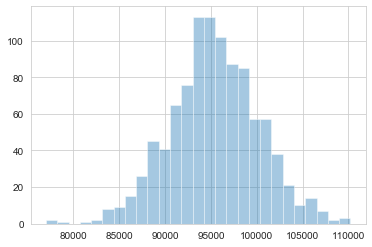

In [12]:
p_list, o_list = mc_simulation(Product(1), 3000, 1000)
sns.distplot(
    p_list,
    kde=False
)
plt.show()

In [16]:
print([np.mean(p_list), np.std(p_list)])

[95454.12823215405, 4924.7318025215345]


In [17]:
print(np.mean(o_list))

0.0665380956183336


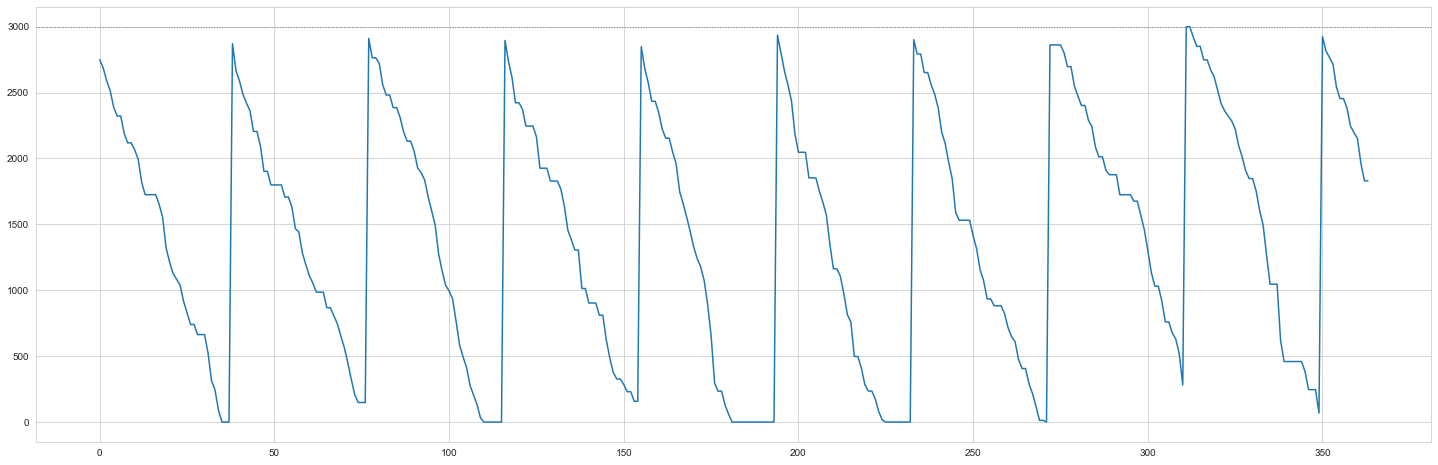

In [11]:
data = monte_carlo_ray(3000, product_1)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [231]:
def periodic_review(product, low, high, step=50):
    m_range = [i for i in range(low, high, step)]
    review_dict = {}

    for M in m_range:
        p_list, o_list = mc_simulation(product, M)
        review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

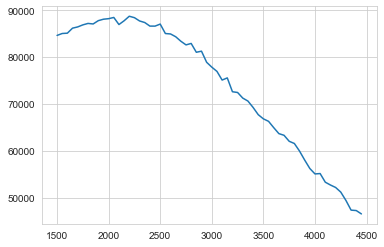

In [233]:
review = periodic_review(Product(1), 1500, 4500)
xx = [i for i in review.keys()]
yy = []
for val in review.values():
    yy.append(val[0])

plt.plot(xx, yy)
plt.show()

In [234]:
max(review.items(), key=operator.itemgetter(1))

(2200,
 (88716.48491604134,
  82120.05828728252,
  95951.45670102465,
  4160.112019918497,
  0.061310704954492735))

In [243]:
# creating a dataframe with all the results
idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']
review = periodic_review(Product(1), 2500, 4000, 10)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(2), 23000, 24000, 10)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(3), 6200, 6800, 10)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

review = periodic_review(Product(4), 2000, 2400, 10)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

In [244]:
df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]]})

In [245]:
df_product_review = df_product_review.set_index(pd.Index(idx))
df_product_review

,1,2,3,4
Order-point M,2500.000000,23020.000000,6240.000000,2010.000000
Expected Profit,86659.288707,341387.265477,143267.169829,302223.308928
Profit Standard Deviation,4599.749013,1086.006075,9752.115263,35574.330385
Proportion of Lost Orders,0.030567,0.000000,0.018816,0.032723


In [110]:
df_product_review = df_product_review.set_index(pd.Index(idx))
df_product_review

,1,2,3,4
Order-point M,2910.000000,23330.000000,6690.000000,2100.000000
Expected Profit,96042.499781,369499.571720,194457.728422,322838.215214
Profit Standard Deviation,4674.771665,735.550308,8013.906551,25584.168878
Proportion of Lost Orders,0.083989,0.003980,0.043220,0.070796


In [270]:
def p_review_optimum(product, M, sim=1000):
    review_dict = {}
    p_list, o_list = mc_simulation(product, M, sim)
    review_dict[M] = (np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

In [272]:
# Product 1: 2071
# Product 2: 18424
# Product 3: 4154
# Product 4: 1305
# creating a dataframe with all the results
idx = ['Order-point M', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']

review = p_review_optimum(Product(1), 2701)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))
review = p_review_optimum(Product(2), 18424)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))
review = p_review_optimum(Product(3), 4154)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))
review = p_review_optimum(Product(4), 1305)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

df_product_review = pd.DataFrame(
    {'1': [prod_review_1[0], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
     '2': [prod_review_2[0], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
     '3': [prod_review_3[0], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
     '4': [prod_review_4[0], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]]})

df_product_review = df_product_review.set_index(pd.Index(idx))
df_product_review

,1,2,3,4
Order-point M,2701.000000,18424.000000,4154.000000,1305.000000
Expected Profit,83354.374623,372188.204545,165594.927642,320506.618858
Profit Standard Deviation,5035.025681,1454.087292,6560.952235,29863.522266
Proportion of Lost Orders,0.018057,0.010143,0.049532,0.073687


## Continuous Review

In [221]:
def cc_monte_carlo_ray(product, q, r):
    inventory = product.starting_stock
    mean = product.mean
    sd = product.sd
    lead_time = product.lead_time
    probability = product.probability

    order_placed = False
    order_time = 0
    stock_out = 0
    # dictionary to store all the information
    data = {'inv_level': [], 'daily_demand': [], 'units_sold': [], 'units_lost': [], 'orders': []}

    
    for day in range(1, 365):
        day_demand = daily_demand(mean, sd, probability)
        data['daily_demand'].append(day_demand)

        if inventory <= r and not order_placed:
            # Time to place an order
            order_placed = True
            order_time = day

        if order_placed and (day-order_time) == lead_time:
            data['orders'].append(q)
            inventory += q
            order_placed = False
            order_time = 0
            
        if inventory - day_demand >= 0:
            data['units_sold'].append(day_demand)
            inventory -= day_demand
        elif inventory - day_demand < 0:
            data['units_sold'].append(inventory)
            data['units_lost'].append(day_demand - inventory)
            inventory = 0
            stock_out += 1

        data['inv_level'].append(inventory)

    return data

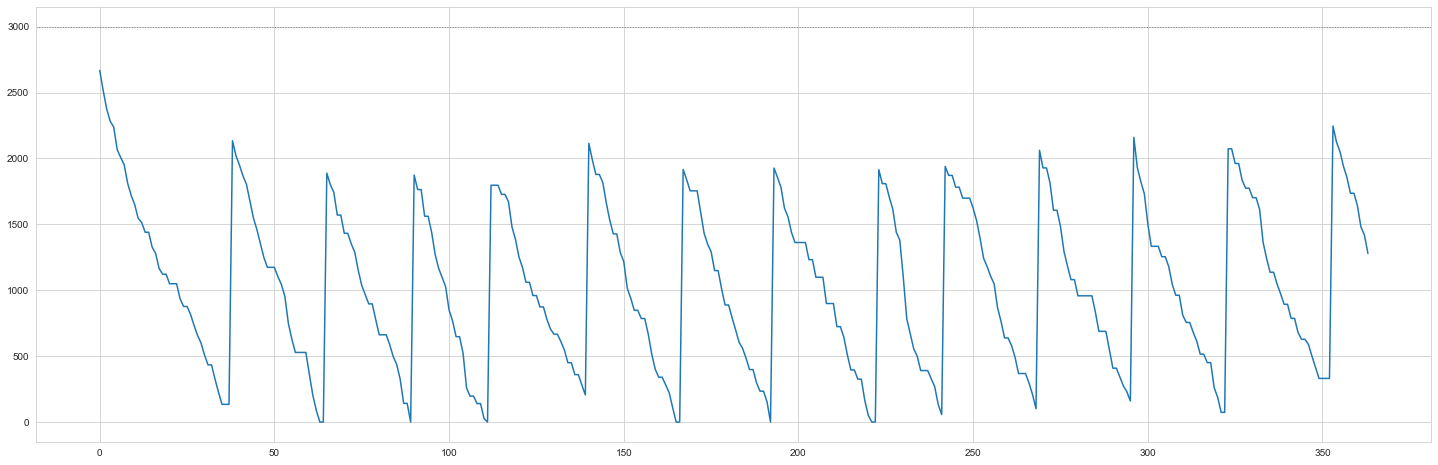

In [222]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)
plt.figure(figsize=(25,8))
plt.plot(data['inv_level'])
plt.axhline(3000, linewidth=1, color="grey", linestyle=":")
plt.show()

In [15]:
data = cc_monte_carlo_ray(Product(1), 2000, 700)

In [16]:
len(data['orders'])

13

In [17]:
def cc_mc_simulation(product, q, r, num_simulations=50):
    profit_list = []
    orders_lost_list = []
    for sim in range(num_simulations):
        data = cc_monte_carlo_ray(product, q, r)
        # Calculating the profit
        profit = calculate_profit(data, product)
        profit_list.append(profit)
        # Calculating the orders lost
        total_demand = sum(data['daily_demand'])
        unsold_orders = sum(data['units_lost'])
        orders_lost_list.append(unsold_orders/total_demand)

    return profit_list, orders_lost_list

In [18]:
p_list, o_list = cc_mc_simulation(Product(1), 2000, 700, 1000)
print([np.mean(p_list), np.std(p_list)])

[108832.39646631153, 8592.610428950817]


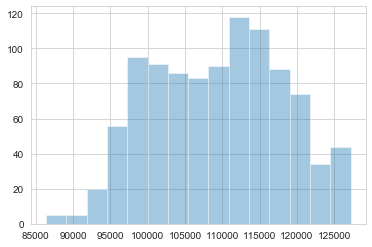

In [21]:
sns.distplot(
    p_list,
    kde=False
)
plt.show()

In [179]:
def continous_review(product, q_guess, r_guess):
    q_low = q_guess - 1000
    q_high = q_guess + 1000
    q_range = [i for i in range(int(q_low), int(q_high), 10)]

    r_low = r_guess - 300
    r_high = r_guess + 300
    r_range = [i for i in range(int(r_low), int(r_high), 10)]

    review_dict = {}

    for q in q_range:
        for r in r_range:
            p_list, o_list = cc_mc_simulation(product, q, r)
            review_dict[(q, r)] = (
                np.mean(p_list), np.quantile(p_list, 0.05), np.quantile(p_list, 0.95), np.std(p_list), np.mean(o_list))

    return review_dict

#review = continous_review(Product(1), 2000, 700)

In [21]:
cc_review = continous_review(Product(1), 2000, 700)

In [22]:
from mpl_toolkits.mplot3d import Axes3D 

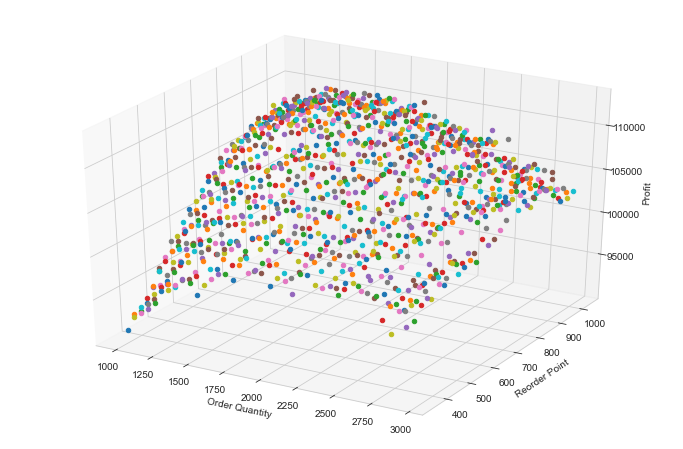

In [107]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for key, val in cc_review.items():
    ax.scatter(key[0], key[1], val[0], marker = 'o')

ax.set_xlabel('Order Quantity')
ax.set_ylabel('Reorder Point')
ax.set_zlabel('Profit')

plt.show()

In [169]:
cc_review = continous_review(Product(1), 2002, 812)

In [108]:
max(review.items(), key=operator.itemgetter(1))

((1600, 825),
 (112665.05056769702,
  101649.67352898626,
  125685.94534605007,
  7561.054946947037,
  0.03177946885333878))

In [113]:
# creating a dataframe with all the results
idx = ['Order Quantity', 'Reorder Point', 'Expected Profit', 'Profit Standard Deviation', 'Proportion of Lost Orders']
review = continous_review(Product(1), 2000, 700)
prod_review_1 = max(review.items(), key=operator.itemgetter(1))

review = continous_review(Product(2), 22500, 2600)
prod_review_2 = max(review.items(), key=operator.itemgetter(1))

review = continous_review(Product(3), 3500, 2500)
prod_review_3 = max(review.items(), key=operator.itemgetter(1))

review = continous_review(Product(4), 1150, 1150)
prod_review_4 = max(review.items(), key=operator.itemgetter(1))

In [122]:
df_cc_review = pd.DataFrame(
        {'1': [prod_review_1[0][0], prod_review_1[0][1], prod_review_1[1][0], prod_review_1[1][3], prod_review_1[1][4]],
         '2': [prod_review_2[0][0], prod_review_2[0][1], prod_review_2[1][0], prod_review_2[1][3], prod_review_2[1][4]],
         '3': [prod_review_3[0][0], prod_review_3[0][1], prod_review_3[1][0], prod_review_3[1][3], prod_review_3[1][4]],
         '4': [prod_review_4[0][0], prod_review_4[0][1], prod_review_4[1][0], prod_review_4[1][3], prod_review_4[1][4]]})

In [123]:
df_cc_review = df_cc_review.set_index(pd.Index(idx))
df_cc_review

,1,2,3,4
Order Quantity,1850.000000,22350.000000,3350.000000,1150.000000
Reorder Point,825.000000,2825.000000,2725.000000,1150.000000
Expected Profit,113305.635713,488147.417157,200275.005181,390542.242843
Profit Standard Deviation,6486.337576,4862.295020,10126.328780,35229.299452
Proportion of Lost Orders,0.028578,0.055202,0.010148,0.022566


In [127]:
p_list, o_list = cc_mc_simulation(Product(2), 25513, 2638, 10000)
print([np.mean(p_list), np.std(p_list)])

[467790.62919030513, 5430.26335727599]


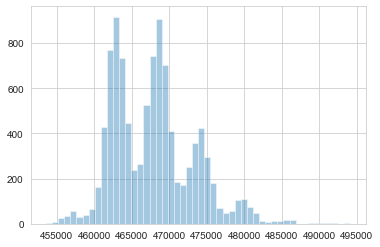

In [128]:
sns.distplot(
    p_list,
    kde=False
)
plt.show()

In [129]:
np.mean(o_list)

0.055141650618583116

### Find the optimum value 

### Periodic Review

In [263]:
product = Product(4)
def fn(args):
    M = args[0][0]
    
    p_list, o_list = mc_simulation(product, M, 500)
    
    print(f' M : {M}, Profit : ${np.mean(p_list):.2f}') 
    return -np.mean(p_list)

In [264]:
bounds = [{'name':'M', 'type':'discrete', 'domain': range(10,10000)}]

Op = BayesianOptimization(f = fn,
                         domain = bounds,
                         model_type = 'GP',
                         acquisition_type = 'EI',
                         exact_feval = False,
                         maximize = False,
                         normalize_Y = False)

Op.run_optimization(max_iter=100)

 M : 8564.0, Profit : $-62147.29
 M : 4575.0, Profit : $156476.17
 M : 2384.0, Profit : $279090.77
 M : 1240.0, Profit : $319304.16
 M : 2762.0, Profit : $254034.81
 M : 2379, Profit : $278839.29
 M : 2380, Profit : $281127.72
 M : 1297, Profit : $321277.65
 M : 1303, Profit : $322316.54
 M : 1309, Profit : $318693.07
 M : 1305, Profit : $323975.37
 M : 1311, Profit : $319215.17
 M : 1307, Profit : $320363.83
 M : 1307, Profit : $318037.02


In [265]:
Op.x_opt

array([1305.])

### Continuous Review

In [161]:
def optimizer(args):
    
    q = args[0][0]
    r = args[0][1]
    
    product = Product(4)
    p_list, o_list = cc_mc_simulation(product, q, r, 500)
    
    print(f' q : {q}, r : {r}, Profit : ${np.mean(p_list):.2f}')
    
    return -np.mean(p_list)

In [165]:
from GPyOpt.methods import BayesianOptimization

bounds = [{'name':'Q', 'type':'discrete', 'domain': range(10,5000)},
         {'name': 'r', 'type':'discrete', 'domain': range(10,5000)}]

Op = BayesianOptimization(f = optimizer,
                         domain = bounds,
                         model_type = 'GP',
                         acquisition_type = 'EI',
                         exact_feval = False,
                         maximize = False,
                         normalize_Y = False)

Op.run_optimization(max_iter=100)

#Op.plot_acquisition()
#Op.Y

 q : 2835.0, r : 4056.0, Profit : $186410.79
 q : 4288.0, r : 276.0, Profit : $265851.56
 q : 2719.0, r : 1400.0, Profit : $335889.17
 q : 3515.0, r : 4892.0, Profit : $115261.84
 q : 2896.0, r : 2893.0, Profit : $245381.43
 q : 294, r : 3206, Profit : $210068.66
 q : 3031, r : 3867, Profit : $189974.33
 q : 4520, r : 380, Profit : $262544.19
 q : 1119, r : 2578, Profit : $309741.69
 q : 776, r : 2286, Profit : $369692.76
 q : 4098, r : 2572, Profit : $219737.17
 q : 3789, r : 2246, Profit : $258899.44
 q : 1606, r : 1333, Profit : $366792.55
 q : 2375, r : 650, Profit : $342985.65
 q : 3624, r : 1445, Profit : $301727.82
 q : 687, r : 921, Profit : $342108.00
 q : 2377, r : 630, Profit : $339434.76
 q : 545, r : 1800, Profit : $318968.62
 q : 1372, r : 701, Profit : $354547.31
 q : 1068, r : 1952, Profit : $343620.37
 q : 1978, r : 1082, Profit : $361024.95
 q : 382, r : 10, Profit : $184590.19
 q : 1282, r : 1097, Profit : $375771.43
 q : 1455, r : 1079, Profit : $373767.38
 q : 1196

In [166]:
Op.x_opt

array([1021., 1130.])

In [ ]:
# Product 2: array([21150.,  4036.])
# Product 1: array([2002.,  812.])
# Product 3: array([3318., 2877.])
# Product 4: array([1099., 1221.]) 383437.71

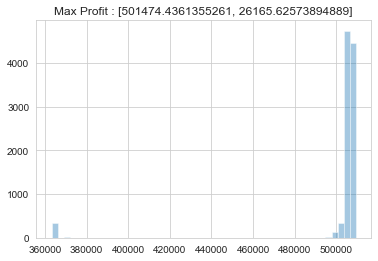

In [37]:
p_list, o_list = cc_mc_simulation(Product(2), 21150, 4036, 10000)

sns.distplot(
    p_list,
    kde=False
)
plt.title(f'Max Profit : {[np.mean(p_list), np.std(p_list)]}')
                           
plt.show()

#print([np.mean(p_list), np.std(p_list)])

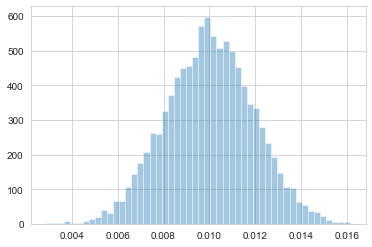

In [39]:
sns.distplot(
    o_list,
    kde=False
)

In [42]:
np.std(o_list)

0.0019119662339925198

### Safety Stock

In [28]:
# Drawing from the original distribution

for i in range(4):
    print(f"Expected Demand Product {i+1} during lead time - {summary['Lead Time'].iloc[i] * np.mean(demand[i+1]):.2f} \n")

Expected Demand Product 1 during lead time - 705.00 

Expected Demand Product 2 during lead time - 3891.31 

Expected Demand Product 3 during lead time - 2265.84 

Expected Demand Product 4 during lead time - 784.79 



In [29]:
demand_lead_time = []
for i in range(4):
    demand_lead_time.append(summary['Lead Time'].iloc[i] * np.mean(demand[i+1]))

In [187]:
r_star = [812, 4036, 2877, 1221]

for i in range(4):
    print(f'Safety Stock for Product {i} is : {round(r_star[i] - demand_lead_time[i], 0)}')

Safety Stock for Product 0 is : 107.0
Safety Stock for Product 1 is : 145.0
Safety Stock for Product 2 is : 611.0
Safety Stock for Product 3 is : 436.0


## Plotting function

In [286]:
def plot_periodic_review(product, low, high, step=50):
    
    review = periodic_review(product, low, high, step)
    optimum = max(review.items(), key=operator.itemgetter(1))
    
    xx = [i for i in review.keys()]
    yy = []
    y_sd_1 = []
    y_sd_2 = []
    y_sd = []
    for val in review.values():
        yy.append(val[0])
        y_sd_1.append(val[1])
        y_sd_2.append(val[2])
        y_sd.append(val[3])

    fig, ax = plt.subplots(nrows=1, ncols=1)
    plt.plot(xx, yy, linewidth=2)
    plt.fill_between(xx, y_sd_1, y_sd_2, alpha=.25)
    #plt.axvline(x = optimum[0], color='k', alpha = .5, ls = '--')
    plt.axvline(x = 2071, color='k', alpha = .5, ls = '--')

    ax.set_ylabel('Profit')
    ax.set_xlabel('M')
    ax.set_title('Simulation of Profit')
    plt.savefig('Pictures/sim_pr.png', dpi = 200)

In [278]:
def plot_inventory(product, M):
    data = monte_carlo_ray(M, product)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,8))
    plt.plot(data['inv_level'], linewidth = 1.5)
    plt.axhline(M, linewidth=2, color="grey", linestyle=":")
    plt.axhline(0, linewidth=2, color="grey", linestyle=":")
    plt.xlim(0,365)
    ax.set_ylabel('Inventory Level (units)', fontsize=18)
    ax.set_xlabel('Day', fontsize=18)
    ax.set_title(f"Periodic Review Model : Number of Orders {len(data['orders'])}", fontsize=18)
    plt.savefig('Pictures/inv_level.png', dpi = 200)

In [275]:
def plot_profit_orders(product, M):
    p_list, o_list = mc_simulation(product, M, 10000)
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.distplot(p_list, kde=False, ax=ax[0])
    ax[0].set_title(f'Profit Distribution : Mean {np.mean(p_list):.2f}')
    ax[0].axvline(x = np.mean(p_list), color='k', alpha = .5, ls = '--')
    sns.distplot(o_list, kde=False, ax=ax[1])
    ax[1].set_title(f'Orders Lost : Mean {np.mean(o_list):.3f}')
    ax[1].axvline(x = np.mean(o_list), color='k', alpha = .5, ls = '--')
    plt.tight_layout()
    print(np.mean(p_list), np.std(p_list))
    plt.savefig('Pictures/profit_dist.png', dpi = 200)
    

In [197]:
def plot_cr_profit_orders(product, q, r):
    p_list, o_list = cc_mc_simulation(product, q, r, 10000)
    f, ax = plt.subplots(1, 2, figsize=(10, 4))
    sns.distplot(p_list, kde=False, ax=ax[0])
    ax[0].set_title(f'Profit Distribution : Mean {np.mean(p_list):.2f}')
    ax[0].axvline(x = np.mean(p_list), color='k', alpha = .5, ls = '--')
    sns.distplot(o_list, kde=False, ax=ax[1])
    ax[1].set_title(f'Orders Lost : Mean {np.mean(o_list):.3f}')
    ax[1].axvline(x = np.mean(o_list), color='k', alpha = .5, ls = '--')
    plt.tight_layout()
    print(np.mean(p_list), np.std(p_list))
    plt.savefig('Pictures/cc_profit_dist.png', dpi = 200)

In [195]:
def plot_cr_inventory(product, q, r):
    data = cc_monte_carlo_ray(product, q, r)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(25,8))
    plt.plot(data['inv_level'], linewidth = 1.5)
    #plt.axhline(M, linewidth=2, color="grey", linestyle=":")
    plt.axhline(0, linewidth=2, color="grey", linestyle=":")
    plt.xlim(0,365)
    ax.set_ylabel('Inventory Level (units)', fontsize=18)
    ax.set_xlabel('Day', fontsize=18)
    ax.set_title(f"Continuous Review Model : Number of Orders {len(data['orders'])}", fontsize=18)
    plt.savefig('Pictures/cc_inv_level.png', dpi = 200)

In [126]:
ax

In [81]:
ax.annotate((3000, 90000))

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a29b79cd0>)

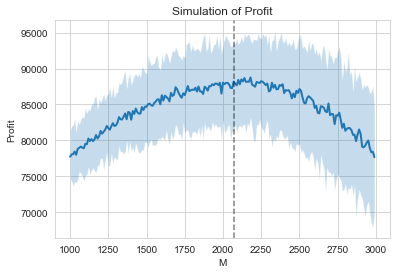

In [287]:
plot_periodic_review(Product(1), 1000, 3000, 10)

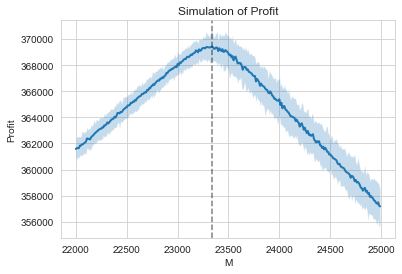

In [105]:
plot_periodic_review(Product(2), 22000, 25000, 10)

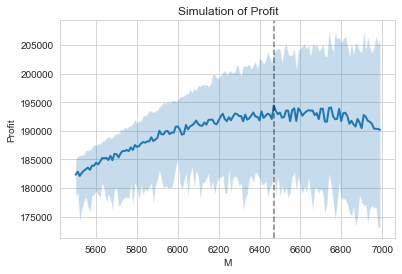

In [106]:
plot_periodic_review(Product(3), 5500, 7000, 10)

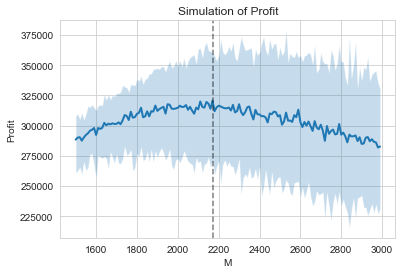

In [107]:
plot_periodic_review(Product(4), 1500, 3000, 10)

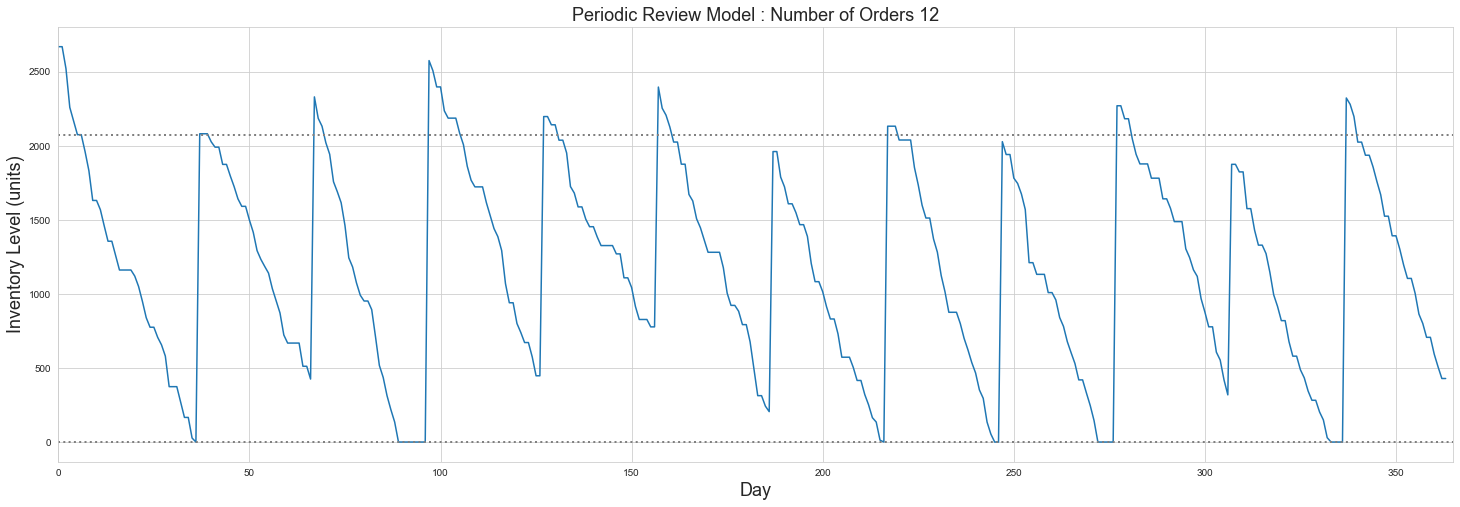

In [279]:
plot_inventory(Product(1), 2071)

In [ ]:
# Product 1: 2071
# Product 2: 18424
# Product 3: 4154
# Product 4: 1305

87863.3342331631 3667.1399014481394


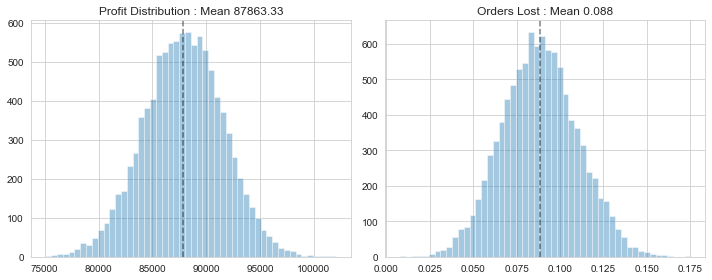

In [285]:
plot_profit_orders(Product(1), 2000)

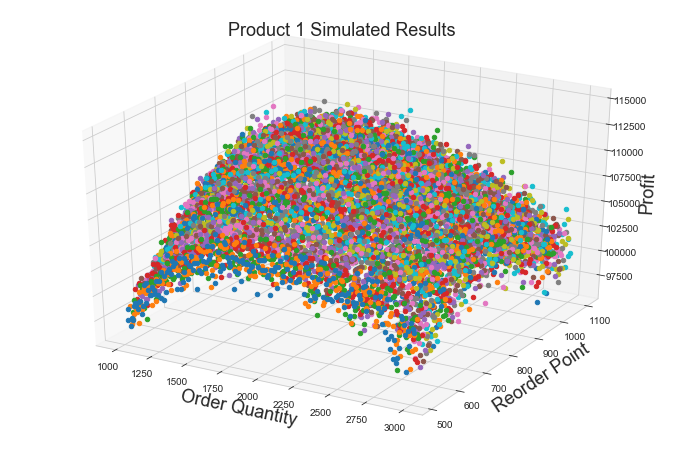

In [180]:
cc_review = continous_review(Product(1), 2002, 812)
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')

for key, val in cc_review.items():
    ax.scatter(key[0], key[1], val[0], marker = 'o')

ax.set_xlabel('Order Quantity', fontsize=18)
ax.set_ylabel('Reorder Point', fontsize=18)
ax.set_zlabel('Profit', fontsize=18)
ax.set_title('Product 1 Simulated Results', fontsize=18)

plt.savefig('Pictures/3d_plot.png', dpi = 200)
plt.show()

In [ ]:
# Product 2: array([21150.,  4036.])
# Product 1: array([2002.,  812.])
# Product 3: array([3318., 2877.])
# Product 4: array([1099., 1221.]) 383437.71

110280.47527902896 8871.41464096155


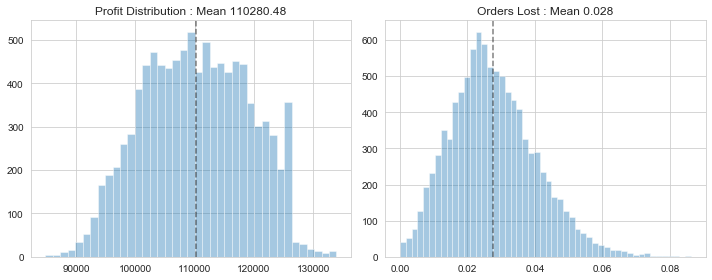

In [198]:
plot_cr_profit_orders(Product(1), 2002, 812)

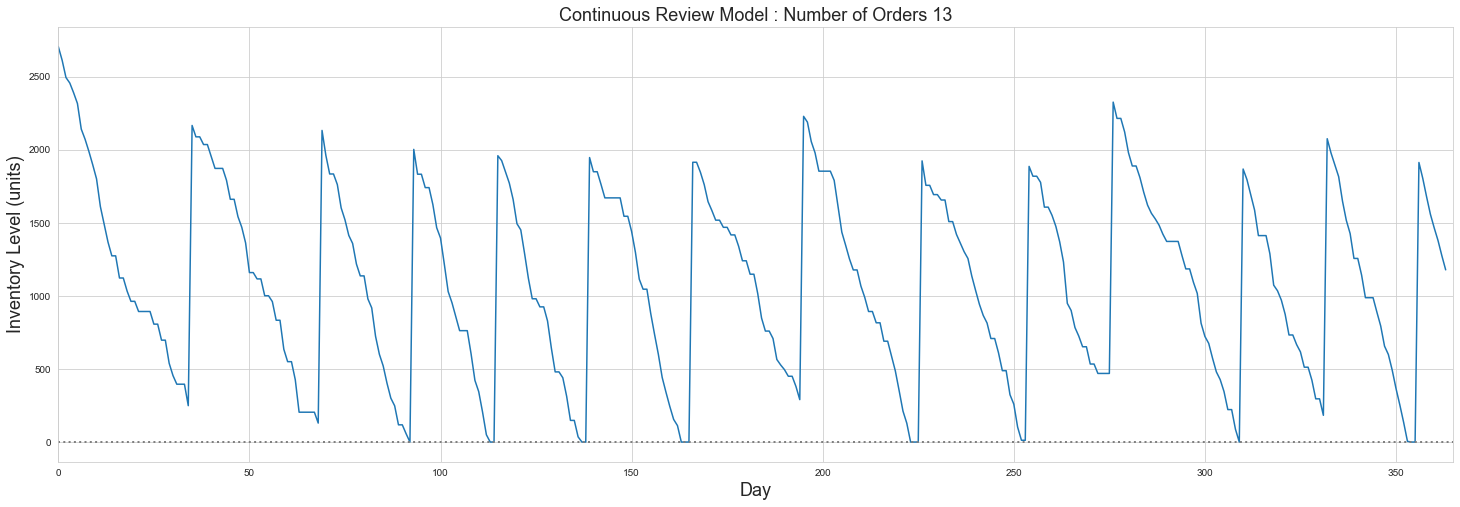

In [196]:
plot_cr_inventory(Product(1), 2002, 812)